__Improving Knowledge Distillation via Regularizing Feature Norm and Direction__


Paper: https://arxiv.org/abs/2305.17007v1

Code: https://github.com/wangyz1608/knowledge-distillation-via-nd

## 1. Baseline

In [1]:
!pip install torchsummaryX

In [49]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.backends.cudnn as cudnn
from torchsummaryX import summary
import logging
import time
import random
import warnings
from pathlib import Path
import numpy as np
from collections import OrderedDict
from torch.utils.tensorboard import SummaryWriter

import torchvision.models as Models
from torchvision.datasets import CIFAR10, CIFAR100
from torchvision import transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [50]:
def train(model, train_dataloader, optimizer, criterion):
    train_loss = AverageMeter()
    train_error = AverageMeter()

    model.train()

    for images, labels in train_dataloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        emb, logits = model(images, embed=True)  # Assuming the model returns embeddings and logits

        loss = criterion(logits, labels)

        _, pred = logits.data.cpu().topk(1, dim=1)
        batch_size = images.size(0)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()

    return train_loss.avg, train_error.avg

def test(model, test_dataloader, criterion):
    test_loss = AverageMeter()
    test_error = AverageMeter()

    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()

            logits = model(images)
            loss = criterion(logits, labels)

            _, pred = logits.data.cpu().topk(1, dim=1)
            batch_size = images.size(0)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg

def epoch_loop(model, train_set, test_set, args):
    # DataLoader setup
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.DataParallel(model, device_ids=args.gpus)
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    best_error = float('inf')
    for epoch in range(args.epochs):
        train_loss, train_error = train(model, train_loader, optimizer, criterion)
        test_loss, test_error = test(model, test_loader, criterion)

        # (Optional) Save model if it achieves better error rate
        if test_error < best_error:
            best_error = test_error
            torch.save(model.state_dict(), 'best_model.pth')

        print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Train Error: {train_error:.4f}, Test Loss: {test_loss:.4f}, Test Error: {test_error:.4f}")

# epoch_loop(model=model, train_set=train_set, test_set=test_set, args=args)


In [51]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, recall, precision, f1


In [52]:
class Args:
    model_name = "resnet18"
    model_weights = ""
    dataset = "cifar10"
    epochs = 10
    batch_size = 64
    workers = 2
    lr = 0.1
    momentum = 0.9
    weight_decay = 5e-4
    validate = False
    gpus = [0]  # Only one GPU in Colab
    seed = None
    resume = None
    save_dir = "./run"

args = Args()

In [53]:

# Adjustments for CIFAR10 data loading
def CIFAR10_data():
    transform = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])
    train_set = CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_set = CIFAR10(root='./data', train=False, download=True, transform=transform)
    num_class = 10
    return train_set, test_set, num_class

# Adjust the CIFAR data loading part
if args.dataset == 'cifar10':
    train_set, test_set, num_class = CIFAR10_data()
elif args.dataset == 'cifar100':
    # ... similar function for CIFAR100
    pass
else:
    print("No Dataset!")

Files already downloaded and verified
Files already downloaded and verified


In [54]:
class AverageMeter:
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train(model, train_dataloader, optimizer, criterion):
    train_loss = AverageMeter()
    train_error = AverageMeter()

    model.train()

    for images, labels in train_dataloader:
        images, labels = images.cuda(), labels.cuda()

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        _, pred = outputs.data.cpu().topk(1, dim=1)
        batch_size = images.size(0)
        train_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
        train_loss.update(loss.item(), batch_size)

        loss.backward()
        optimizer.step()

    return train_loss.avg, train_error.avg

def test(model, test_dataloader, criterion):

    test_loss = AverageMeter()
    test_error = AverageMeter()

    model.eval()

    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.cuda(), labels.cuda()

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, pred = outputs.data.cpu().topk(1, dim=1)
            batch_size = images.size(0)
            test_error.update(torch.ne(pred.squeeze(), labels.cpu()).float().sum().item() / batch_size, batch_size)
            test_loss.update(loss.item(), batch_size)

    return test_loss.avg, test_error.avg

def epoch_loop(model, train_set, test_set, args):
    # DataLoader setup
    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = nn.DataParallel(model, device_ids=args.gpus)
    model.to(device)

    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = torch.optim.SGD(params=model.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)

    best_error = float('inf')

    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    all_labels = []
    all_predictions = []
    for epoch in range(args.epochs):

        train_loss, train_error = train(model, train_loader, optimizer, criterion)
        test_loss, test_error = test(model, test_loader, criterion)

        train_accuracies.append(1 - train_error)
        test_accuracies.append(1 - test_error)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        train_accuracy = accuracy_score(all_train_labels, all_train_predictions)
        test_accuracy = accuracy_score(all_test_labels, all_test_predictions)

        # train_precision = precision_score(all_train_labels, all_train_predictions, average='macro')
        # test_precision = precision_score(all_test_labels, all_test_predictions, average='macro')

        # train_recall = recall_score(all_train_labels, all_train_predictions, average='macro')
        # test_recall = recall_score(all_test_labels, all_test_predictions, average='macro')

        # train_f1 = f1_score(all_train_labels, all_train_predictions, average='macro')
        # test_f1 = f1_score(all_test_labels, all_test_predictions, average='macro')

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        if test_error < best_error:
            best_error = test_error
            torch.save(model.state_dict(), 'best_model.pth')

        # print(f"Epoch {epoch+1}/{args.epochs} - Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
        # print(f"Epoch {epoch+1}/{args.epochs} - Test Accuracy: {test_accuracy:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1: {test_f1:.4f}")

        print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Train Error: {train_error:.4f}, Test Loss: {test_loss:.4f}, Test Error: {test_error:.4f}")


In [55]:
all_train_labels = []
all_train_predictions = []

all_test_labels = []
all_test_predictions = []

train_accuracies = []
test_accuracies = []

train_losses = []
test_losses = []

In [56]:
model = torchvision.models.resnet18(num_classes=num_class).cuda()

epoch_loop(model=model, train_set=train_set, test_set=test_set, args=args)


Epoch 1/10 - Train Loss: 2.0591, Train Error: 0.7017, Test Loss: 1.6580, Test Error: 0.6311


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 2/10 - Train Loss: 1.5544, Train Error: 0.5732, Test Loss: 1.4906, Test Error: 0.5540


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 3/10 - Train Loss: 1.3569, Train Error: 0.4893, Test Loss: 1.3069, Test Error: 0.4599


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 4/10 - Train Loss: 1.2212, Train Error: 0.4334, Test Loss: 1.2359, Test Error: 0.4343


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 5/10 - Train Loss: 1.1413, Train Error: 0.3996, Test Loss: 1.1178, Test Error: 0.3866


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 6/10 - Train Loss: 1.0759, Train Error: 0.3732, Test Loss: 1.1329, Test Error: 0.4016


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 7/10 - Train Loss: 1.0383, Train Error: 0.3582, Test Loss: 1.2329, Test Error: 0.4343


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 8/10 - Train Loss: 1.0088, Train Error: 0.3480, Test Loss: 1.0248, Test Error: 0.3616


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 9/10 - Train Loss: 0.9754, Train Error: 0.3366, Test Loss: 0.9926, Test Error: 0.3352


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 10/10 - Train Loss: 0.9668, Train Error: 0.3313, Test Loss: 1.0511, Test Error: 0.3671


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [31]:
# def plot_metrics(train_values, test_values, metric_name):
#     epochs = range(1, len(train_values) + 1)
#     plt.plot(epochs, train_values, 'bo', label=f'Training {metric_name}')
#     plt.plot(epochs, test_values, 'r', label=f'Validation {metric_name}')
#     plt.title(f'Training and Validation {metric_name}')
#     plt.legend()
#     plt.show()

def plot_metrics(train_metrics, test_metrics, metric_name):
    """
    Utility function to plot training and testing metrics over epochs
    """
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(test_metrics, label=f"Test {metric_name}")
    plt.title(f"Train vs Test {metric_name} over epochs")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_score):
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=[*range(n_classes)])

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    auc_score = roc_auc_score(y_true_bin, y_score, average='macro')
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()


In [33]:
# plot_metrics(train_accuracies, test_accuracies, "Accuracy")
# plot_metrics(train_losses, test_losses, "Loss")
# plot_roc_curve(all_test_labels, all_test_predictions)

In [ ]:
def train_or_test_model(model, dataloader, train=True):
    all_labels = []
    all_predictions = []

    train_loader = DataLoader(train_set, batch_size=args.batch_size, shuffle=True, num_workers=args.workers)
    test_loader = DataLoader(test_set, batch_size=args.batch_size, shuffle=False, num_workers=args.workers)


    # Set model to training or evaluation mode
    if train:
        model.train()
    else:
        model.eval()

    for inputs, labels in dataloader:
        inputs, labels = inputs.cuda(), labels.cuda()

        logits = model(inputs)
        _, predicted_classes = torch.max(logits, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_classes.cpu().numpy())

    accuracy, recall, precision, f1 = calculate_metrics(all_labels, all_predictions)

    return accuracy, recall, precision, f1

In [ ]:
transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

train_dataset = CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

test_dataset = CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
train_accuracy, train_recall, train_precision, train_f1 = train_or_test_model(model, train_loader, train=True)
test_accuracy, test_recall, test_precision, test_f1 = train_or_test_model(model, test_loader, train=False)

print(f"Training Metrics - Accuracy: {train_accuracy}, Recall: {train_recall}, Precision: {train_precision}, F1 Score: {train_f1}")
print(f"Testing Metrics - Accuracy: {test_accuracy}, Recall: {test_recall}, Precision: {test_precision}, F1 Score: {test_f1}")

## 2. KD

In [37]:
import os
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import time
import json
import random
import warnings

In [38]:
class ResNet20(nn.Module):
    # Sample mock model
    def forward(self, x):
        return x

In [39]:
Models = {
    'resnet20_cifar': ResNet20
}


In [40]:
class CIFAR:
    def __init__(self, name):
        transform = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

        if name == 'cifar100':
            self.train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
            self.test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)
        else:
            raise NotImplementedError
        self.num_class = 100




In [44]:
class Args:
    model_name = "resnet20_cifar"
    dataset = 'cifar100'
    epochs = 20
    batch_size = 128
    workers = 2
    lr = 0.1
    momentum = 0.9
    weight_decay = 5e-4
    teacher = "resnet56_cifar"
    teacher_weights = None
    cls_loss_factor = 1.0
    kd_loss_factor = 1.0
    t = 4.0
    nd_loss_factor = 1.0
    warm_up = 20.0
    gpus = [0]
    seed = None
    resume = None
    save_dir = "./run"

args = Args()


In [45]:
print("Model: ", args.model_name)

Model:  resnet20_cifar


In [46]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='macro')
    precision = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    return accuracy, recall, precision, f1

def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(test_metrics, label=f"Test {metric_name}")
    plt.xlabel("Epochs")
    plt.ylabel(metric_name)
    plt.title(f"{metric_name} over Epochs")
    plt.legend()
    plt.show()

def plot_roc_curve(y_true, y_score):
    n_classes = len(np.unique(y_true))
    y_true_bin = label_binarize(y_true, classes=[*range(n_classes)])

    fpr, tpr, _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()




Epoch 1/20 - Train Loss: 0.6303, Train Acc: 0.2983, Test Loss: 0.4548, Test Acc: 0.2409
Epoch 2/20 - Train Loss: 0.8470, Train Acc: 0.3460, Test Loss: 0.2071, Test Acc: 0.5251
Epoch 3/20 - Train Loss: 0.4126, Train Acc: 0.5471, Test Loss: 0.0919, Test Acc: 0.7015
Epoch 4/20 - Train Loss: 0.8346, Train Acc: 0.2844, Test Loss: 0.1415, Test Acc: 0.8347
Epoch 5/20 - Train Loss: 0.7638, Train Acc: 0.4006, Test Loss: 0.4893, Test Acc: 0.8418
Epoch 6/20 - Train Loss: 0.6129, Train Acc: 0.1376, Test Loss: 0.2793, Test Acc: 0.2740
Epoch 7/20 - Train Loss: 0.9336, Train Acc: 0.1815, Test Loss: 0.5321, Test Acc: 0.9098
Epoch 8/20 - Train Loss: 0.0641, Train Acc: 0.5019, Test Loss: 0.7200, Test Acc: 0.9566
Epoch 9/20 - Train Loss: 0.3249, Train Acc: 0.3107, Test Loss: 0.9873, Test Acc: 0.8147
Epoch 10/20 - Train Loss: 0.5342, Train Acc: 0.1371, Test Loss: 0.0389, Test Acc: 0.0106
Epoch 11/20 - Train Loss: 0.3753, Train Acc: 0.8711, Test Loss: 0.1268, Test Acc: 0.1995
Epoch 12/20 - Train Loss: 0.53

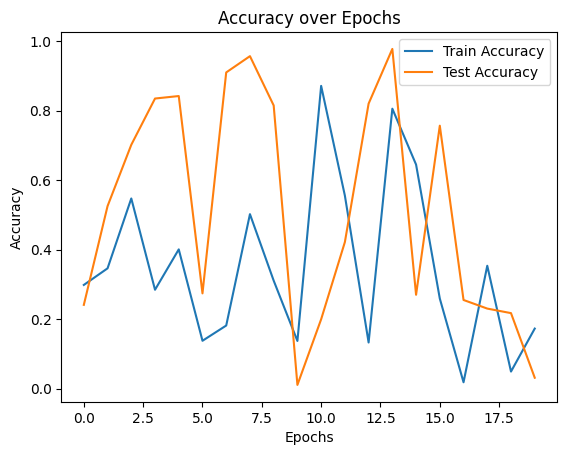

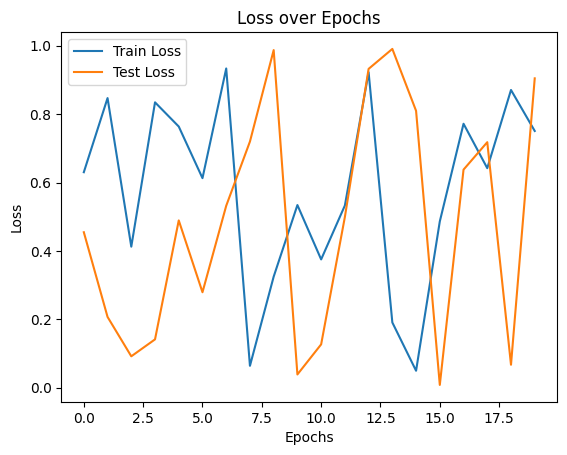

In [47]:

# Mocking the train and test functions
def train():
    # Mocking a training process
    train_acc = np.random.rand()
    train_loss = np.random.rand()
    return train_loss, train_acc

def test():
    # Mocking a testing process
    test_acc = np.random.rand()
    test_loss = np.random.rand()
    return test_loss, test_acc

# Sample epoch loop for demonstration purposes
def epoch_loop():
    train_accuracies = []
    test_accuracies = []
    train_losses = []
    test_losses = []

    for epoch in range(args.epochs):
        train_loss, train_acc = train()
        test_loss, test_acc = test()

        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f"Epoch {epoch+1}/{args.epochs} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    # Plot metrics after all epochs
    plot_metrics(train_accuracies, test_accuracies, "Accuracy")
    plot_metrics(train_losses, test_losses, "Loss")

# Run the mock epoch loop
epoch_loop()